Epoch 1/10
235/235 [==============================] - 2s 5ms/step - loss: 0.0549 - val_loss: 0.0397
Epoch 2/10
235/235 [==============================] - 1s 4ms/step - loss: 0.0389 - val_loss: 0.0379
Epoch 3/10
235/235 [==============================] - 1s 4ms/step - loss: 0.0375 - val_loss: 0.0367
Epoch 4/10
235/235 [==============================] - 1s 4ms/step - loss: 0.0364 - val_loss: 0.0360
Epoch 5/10
235/235 [==============================] - 1s 4ms/step - loss: 0.0355 - val_loss: 0.0351
Epoch 6/10
235/235 [==============================] - 1s 4ms/step - loss: 0.0349 - val_loss: 0.0345
Epoch 7/10
235/235 [==============================] - 1s 5ms/step - loss: 0.0345 - val_loss: 0.0342
Epoch 8/10
235/235 [==============================] - 1s 4ms/step - loss: 0.0341 - val_loss: 0.0339
Epoch 9/10
235/235 [==============================] - 1s 4ms/step - loss: 0.0338 - val_loss: 0.0336
Epoch 10/10
1/1 [==============================] - 0s 56ms/step


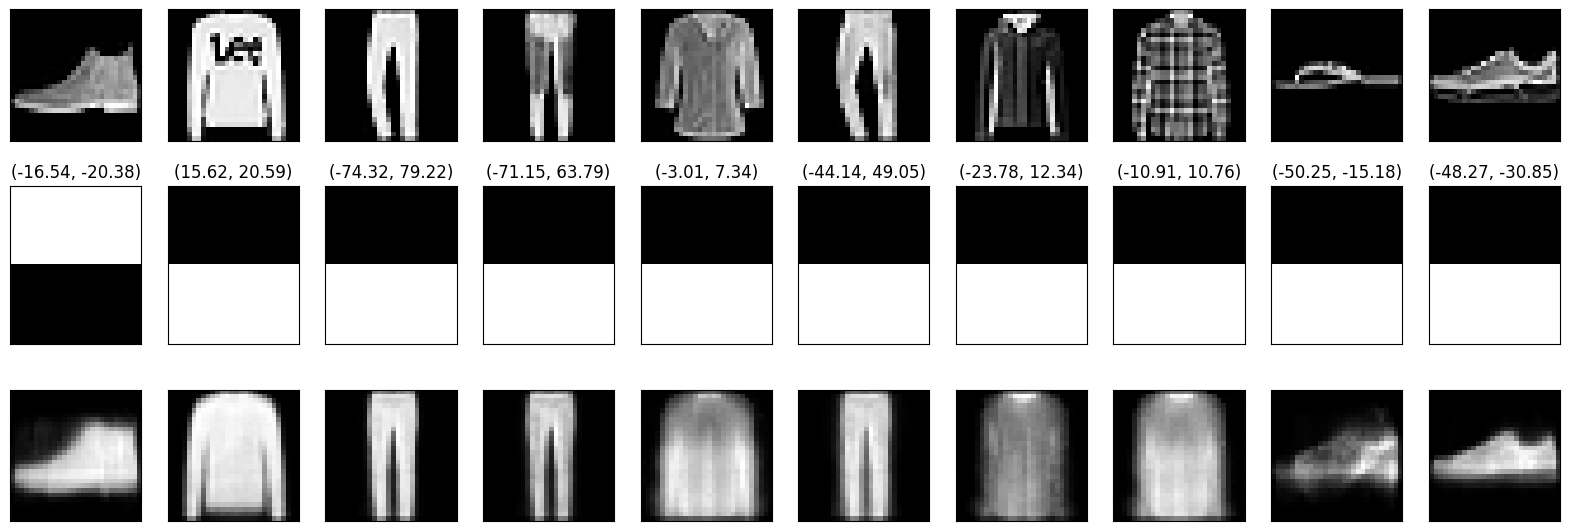

1/1 [==============================] - 0s 20ms/step


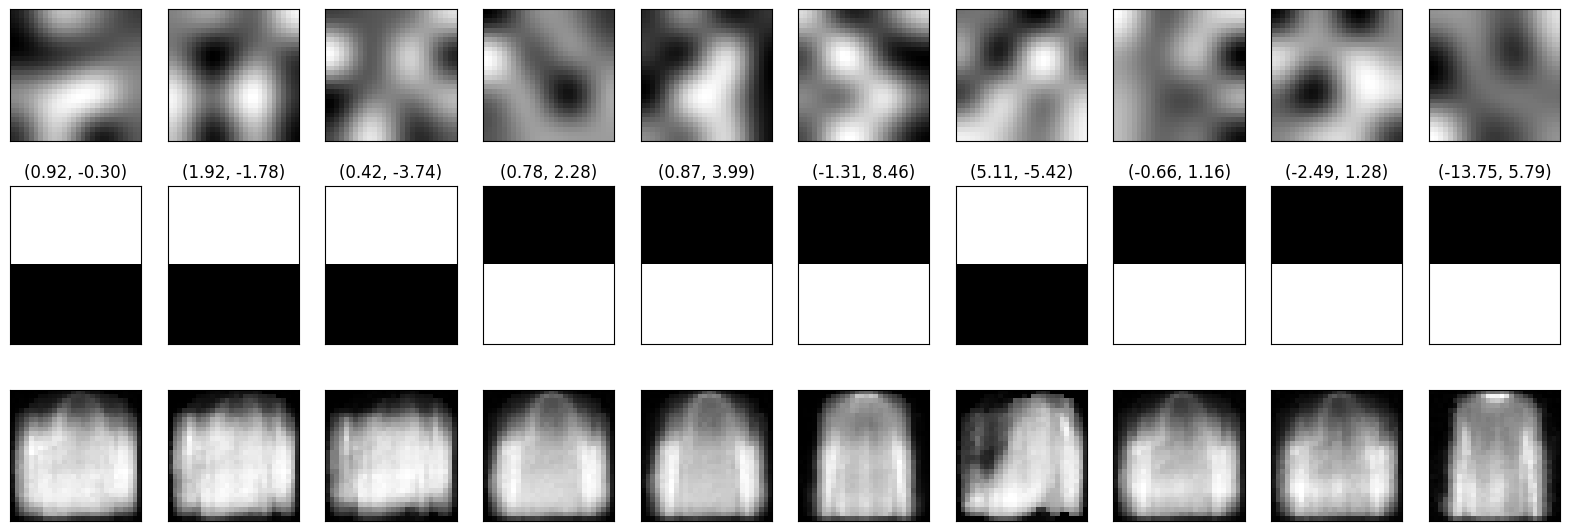

In [16]:
# Import required libraries
import keras
from keras.datasets import fashion_mnist
from keras.models import Model
from keras.layers import Input, Conv2D, Dense, Flatten, UpSampling2D
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage

# Load the Fashion-MNIST dataset and preprocess it
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1) / 255
x_test = x_test.reshape(-1, 28, 28, 1) / 255

# Function to create the autoencoder model (consists of an encoder and a decoder)
def create_autoencoder_model():
    # Define the encoder model
    inputs = Input(shape=(28, 28, 1))
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Flatten()(x)
    encoded = Dense(2, activation='linear')(x)
    encoder = Model(inputs=inputs, outputs=encoded)

    # Define the decoder model
    encoded_inputs = Input(shape=(2,))
    x = Dense(64, activation='relu')(encoded_inputs)
    x = Dense(28 * 28, activation='sigmoid')(x)
    decoded = Reshape((28, 28, 1))(x)
    decoder = Model(inputs=encoded_inputs, outputs=decoded)

    # Define the autoencoder model
    autoencoder_inputs = Input(shape=(28, 28, 1))
    autoencoder_outputs = decoder(encoder(autoencoder_inputs))
    autoencoder_model = Model(inputs=autoencoder_inputs, outputs=autoencoder_outputs)

    # Compile the autoencoder model
    autoencoder_model.compile(optimizer=optimizers.Adam(1e-3), loss='mse')
    return encoder, decoder, autoencoder_model

# Create the autoencoder model
encoder, decoder, autoencoder_model = create_autoencoder_model()

# Train the autoencoder model
autoencoder_model.fit(x_train, x_train, batch_size=256, epochs=10, shuffle=True, validation_data=(x_test, x_test))

# Function to get input images, their latent representations, and decoded images
def get_triple(inputs):
    latent_repr = encoder.predict(inputs)
    outputs = decoder.predict(latent_repr)

    return inputs, latent_repr, outputs

# Function to visualize input images, their latent representations, and decoded images
def show_encodings(inputs, latent_repr, outputs):
    n = len(inputs)
    fig, axes = plt.subplots(3, n, figsize=(2 * n, 7))
    for i in range(n):
        axes[0, i].imshow(inputs[i].reshape(28, 28), cmap='gray')
        axes[1, i].imshow(latent_repr[i].reshape(-1, 1), cmap='gray', aspect='auto')
        axes[2, i].imshow(outputs[i].reshape(28, 28), cmap='gray')
        axes[1, i].set_title('({0:.2f}, {1:.2f})'.format(float(latent_repr[i, 0]), float(latent_repr[i, 1])))
        
    for ax in axes.flatten():
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

show_encodings(*get_triple(x_test[:10]))

inputs = np.random.random(size=(10, 4, 4, 1))
inputs = scipy.ndimage.zoom(inputs, (1, 7, 7, 1))
show_encodings(*get_triple(inputs))

313/313 [==============================] - 0s 1ms/step


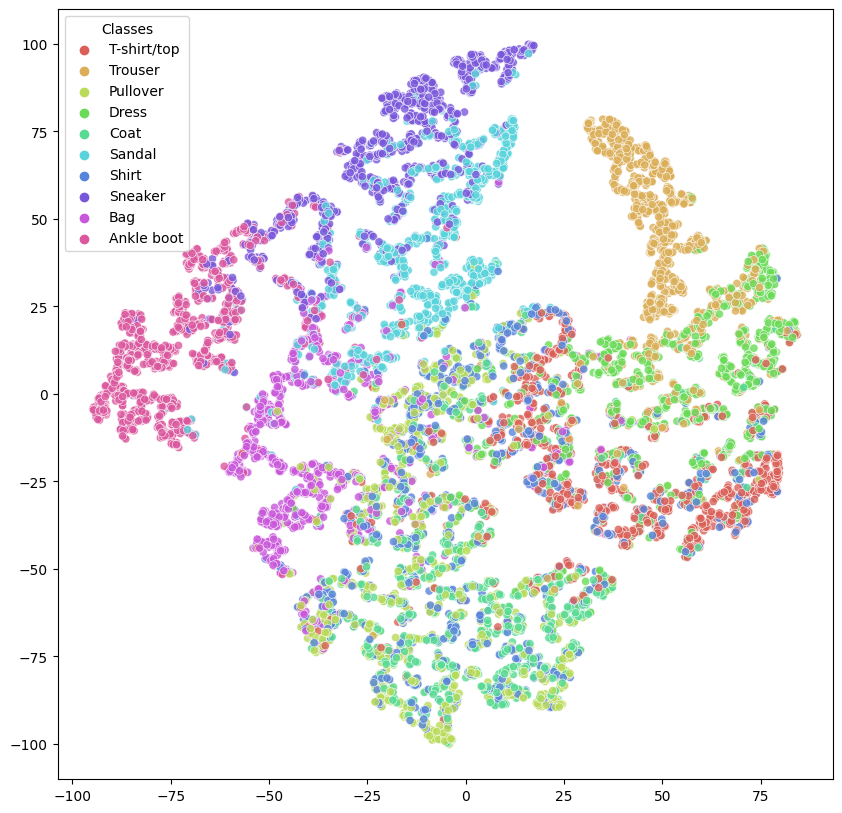

In [18]:
# Import additional libraries
from sklearn.manifold import TSNE
import seaborn as sns

labeldict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

# Additional function to visualize the t-SNE plot with named labels
def plot_tsne(latent_repr, labels):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(latent_repr)
    
    plt.figure(figsize=(10, 10))
    plot = sns.scatterplot(
        x=tsne_results[:, 0], y=tsne_results[:, 1],
        hue=labels,
        palette=sns.color_palette("hls", 10),
        legend="full",
        alpha=0.8
    )
    
    # Set custom legend labels
    legend_labels = [labeldict[int(label.get_text())] for label in plot.get_legend().texts]
    plot.get_legend().set_title("Classes")
    for label, legend_label in zip(plot.get_legend().texts, legend_labels):
        label.set_text(legend_label)

    plt.show()

# Calculate the latent representation of the test data
_, latent_repr, _ = get_triple(x_test)

# Plot t-SNE visualization with named labels
plot_tsne(latent_repr, y_test)